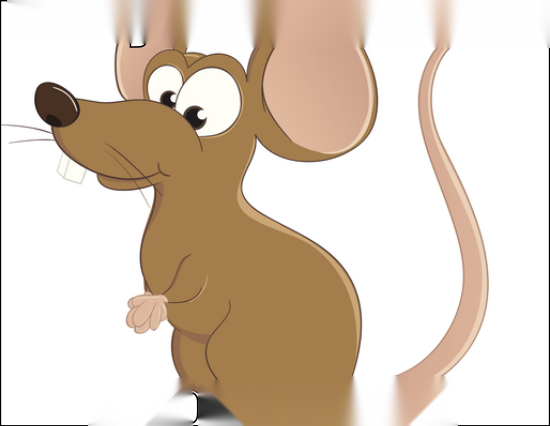

In [2]:
import cv2
import numpy as np
import os

east_model_path = 'frozen_east_text_detection.pb'
if not os.path.exists(east_model_path):
    !wget https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb

def download_east_model(east_model_url='https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb', east_model_path='frozen_east_text_detection.pb'):
    if not os.path.exists(east_model_path):
        !wget {east_model_url} -O {east_model_path}

def decode_predictions(scores, geometry, min_confidence=0.5):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    for y in range(numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        for x in range(numCols):
            if scoresData[x] < min_confidence:
                continue
            offsetX, offsetY = x * 4.0, y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    return rects, confidences


def create_text_mask_for_inpainting(image_path, east_model_path='frozen_east_text_detection.pb', min_confidence=0.5, kernel_size=(5, 5), iterations=1):
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]
    net = cv2.dnn.readNet(east_model_path)
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])
    (rects, confidences) = decode_predictions(scores, geometry, min_confidence)
    indices = cv2.dnn.NMSBoxes(rects, confidences, min_confidence, 0.4)
    mask = np.zeros((newH, newW), dtype="uint8")


    if len(indices) == 0:
        indices = []
    elif isinstance(indices, (np.ndarray, list)) and len(indices.shape) == 1:
        indices = indices.flatten()
    else:
        indices = [indices]

    for i in indices:
        (startX, startY, endX, endY) = rects[i]
        cv2.rectangle(mask, (startX, startY), (endX, endY), 255, -1)

    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size), iterations=iterations)
    mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
    return mask

def inpaint_image_with_opencv(image_path, mask, method=cv2.INPAINT_TELEA):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error loading image")
    if mask is None:
        raise ValueError("Error loading mask")
    if image.shape[:2] != mask.shape:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    inpainted_image = cv2.inpaint(image, mask, 3, method)
    return inpainted_image


def display_image(image, window_name='Image'):
    try:
        from google.colab.patches import cv2_imshow
        cv2_imshow(image)
    except ImportError:
        cv2.imshow(window_name, image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


image_path = '/content/04239.png'
mask = create_text_mask_for_inpainting(image_path)
inpainted_image = inpaint_image_with_opencv(image_path, mask)
cv2.imwrite('inpainted_image.png', inpainted_image)


display_image(inpainted_image)


Cloning into 'yolov5'...
remote: Enumerating objects: 16517, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 16517 (delta 47), reused 50 (delta 16), pack-reused 16402
Receiving objects: 100% (16517/16517), 15.12 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (11309/11309), done.
/content/yolov5/yolov5


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-3-14 Python-3.10.12 torch-2.2.1+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 115MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
image 1/1: 426x550 (no detections)
Speed: 34.2ms pre-process, 361.1ms inference, 14.1ms NMS per image at shape (1, 3, 512, 640)


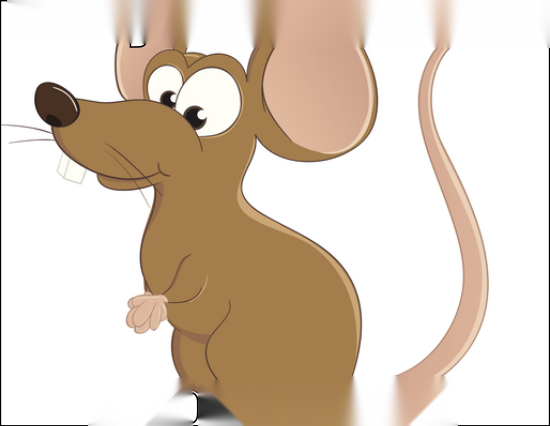

In [4]:

!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def detect_and_draw_box(image_path, model='yolov5s', conf=0.4):

    model = torch.hub.load('ultralytics/yolov5', model, pretrained=True)


    img = Image.open(image_path)


    results = model(img, size=640)


    results.print()
    results.show()


inpainted_image_path = '/content/inpainted_image.png'

detect_and_draw_box(inpainted_image_path)
